##### LOADING NECESSARY LIBRARIES AND CREATING NECESSARY FUNCTIONS

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import custom_vgg22
import preloaded_vgg22
import os

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# function to load preloaded VGGNet model on custom VGGNet model architecture
def model_preload(weights=tf.keras.Model.weights):
    """
    input:
    weights -- weights of the base VGGNet model

    output:
    tf.keras.Model -- VGG22 Model with preloaded_VGG weights but custom_VGG architecture
    
    """
    # purpose of this function is to make later weights and biases comparisons easier
    # by providing the same architecture to both the models
    
    base_model = preloaded_vgg22.cifar10_VGG22()   # loading preloaded VGG22 model
    base_model.load_weights(weights)
    
    preload_model = custom_vgg22.cifar10_custom_VGG22()  # loading custom VGG22 model

    i = 2
    # assigning weights correspondingly from preloaded model to custom model
    for layer in base_model.layers[3].layers:
        preload_model.layers[i].set_weights(layer.weights)  # VGGNet architecture
        i += 1
    
    preload_model.layers[i].set_weights(base_model.layers[4].weights)       # batchnormalization layer
    preload_model.layers[i+3].set_weights(base_model.layers[7].weights)     # fc1 dense layer
    preload_model.layers[i+5].set_weights(base_model.layers[9].weights)     # fc2 dense layer
    preload_model.layers[i+7].set_weights(base_model.layers[11].weights)    # fc3 dense layer
    preload_model.layers[i+9].set_weights(base_model.layers[13].weights)    # fc4 dense layer
    preload_model.layers[i+11].set_weights(base_model.layers[15].weights)   # predictions layer

    return preload_model

In [4]:
# function to generate statistics on the data
def corr_calc(models=[tf.keras.Model, tf.keras.Model]):
    """
    input:
    models -- two tf.keras.Model

    output:
    dictionary -- a dictionary with Pearson and Spearman Correlation Coefficients
    """
    data = {}

    for i in range(len(models[0].layers)):  # looping through the model
        if models[0].layers[i].weights != []:  # excluding layers without weights and biases
            model1_weights = models[0].layers[i].get_weights()[0].flatten()
            model1_biases = models[0].layers[i].get_weights()[1]
            model2_weights = models[1].layers[i].get_weights()[0].flatten()
            model2_biases = models[1].layers[i].get_weights()[1]
            # calculating pearson correlation
            data[models[0].layers[i].name + '_pearson_w'], _ = stats.pearsonr(model1_weights, model2_weights)
            data[models[0].layers[i].name + '_pearson_b'], _ = stats.pearsonr(model1_biases, model2_biases)
            # calculating spearman correlation
            data[models[0].layers[i].name + '_spearman_w'], _ = stats.spearmanr(model1_weights, model2_weights)
            data[models[0].layers[i].name + '_spearman_b'], _ = stats.spearmanr(model1_biases, model2_biases)
            
    return data

In [5]:
# function to transform dictionary to Pandas DataFrame
def dict_to_DF(g_dict=None, checkpoint="checkpoint"):
    """
    input:
    g_dict -- a dictionary with Pearson and Spearman Correlation Coefficients
    checkpoint -- the name of the checkpoint as a string (eg., "Checkpoint 1")

    output:
    Pandas DataFrame -- a Pandas DataFrame
    
    """
    data = pd.DataFrame(list(g_dict.items()), columns=['layer', 'value'])  # creating DataFrame
    # generating correlation column for Pearson or Spearman Correlation Coefficient
    data['correlation'] = data['layer'].apply(lambda x: 'Pearson Correlation' if x.split("_")[-2] == "pearson" else 'Spearman Correlation')
    # generating value category based on weights or biases
    data['value category'] = data['layer'].apply(lambda x: 'Weights' if x.rsplit("_", 1)[-1] == "w" else 'Biases')
    # renaming layer to drop '_w' or '_b' at the end
    data['layer'] = data['layer'].apply(lambda x: x.rsplit("_", 1)[0].rsplit("_", 1)[0])
    # generating a column with checkpoint
    data['checkpoint'] = data.apply(lambda x: checkpoint, axis=1)

    return data

### CHECKPOINT 1 CORRELATION ACROSS TWO MODELS

In [6]:
# loading both models with respective initial weights
custom_model = custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_1.h5')
preload_model = model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_1.h5')

In [7]:
# calculating correlation coefficients across two models
corr_data = corr_calc(models = [preload_model, custom_model])

C:\Users\Vipul\AppData\Local\Temp\ipykernel_19164\3991042076.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  data[models[0].layers[i].name + '_pearson_b'], _ = stats.pearsonr(model1_biases, model2_biases)
C:\Users\Vipul\AppData\Local\Temp\ipykernel_19164\3991042076.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  data[models[0].layers[i].name + '_spearman_b'], _ = stats.spearmanr(model1_biases, model2_biases)
C:\Users\Vipul\AppData\Local\Temp\ipykernel_19164\3991042076.py:19: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  data[models[0].layers[i].name + '_pearson_w'], _ = stats.pearsonr(model1_weights, model2_weights)
C:\Users\Vipul\AppData\Local\Temp\ipykernel_19164\3991042076.py:22: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  data[models[0].layers[i].name + '_spearman_w'], _ = 

In [8]:
# putting together the correlation calculations into a Pandas DataFrame
corr_df = dict_to_DF(g_dict=corr_data, checkpoint="Checkpoint 1")

In [9]:
# assigning new Pandas DataFrames to store all Correlation Values
overall_corr_data = corr_df

### CHECKPOINT 2 CORRELATION ACROSS TWO MODELS

In [10]:
# loading both models with respective initial weights
custom_model = custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_2.h5')
preload_model = model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_2.h5')

In [11]:
# calculating correlation coefficients across two models
corr_data = corr_calc(models = [preload_model, custom_model])

In [12]:
# putting together the correlation calculations into a Pandas DataFrame
corr_df = dict_to_DF(g_dict=corr_data, checkpoint="Checkpoint 2")

In [13]:
# concatinating checkpoint 2 values to previous DataFrames to store all values
overall_corr_data = pd.concat([overall_corr_data, corr_df], ignore_index=True)

### CHECKPOINT 3 CORRELATION ACROSS TWO MODELS

In [14]:
# loading both models with respective initial weights
custom_model = custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_3.h5')
preload_model = model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_3.h5')

In [15]:
# calculating correlation coefficients across two models
corr_data = corr_calc(models = [preload_model, custom_model])

In [16]:
# putting together the correlation calculations into a Pandas DataFrame
corr_df = dict_to_DF(g_dict=corr_data, checkpoint="Checkpoint 3")

In [17]:
# concatinating checkpoint 3 values to previous DataFrames to store all values
overall_corr_data = pd.concat([overall_corr_data, corr_df], ignore_index=True)

### CHECKPOINT 4 CORRELATION ACROSS TWO MODELS

In [18]:
# loading both models with respective initial weights
custom_model = custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_4.h5')
preload_model = model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_4.h5')

In [19]:
# calculating correlation coefficients across two models
corr_data = corr_calc(models = [preload_model, custom_model])

In [20]:
# putting together the correlation calculations into a Pandas DataFrame
corr_df = dict_to_DF(g_dict=corr_data, checkpoint="Checkpoint 4")

In [21]:
# concatinating checkpoint 4 values to previous DataFrames to store all values
overall_corr_data = pd.concat([overall_corr_data, corr_df], ignore_index=True)

### CORRELATION COEFFICIENT VALUES VISUALIZATION

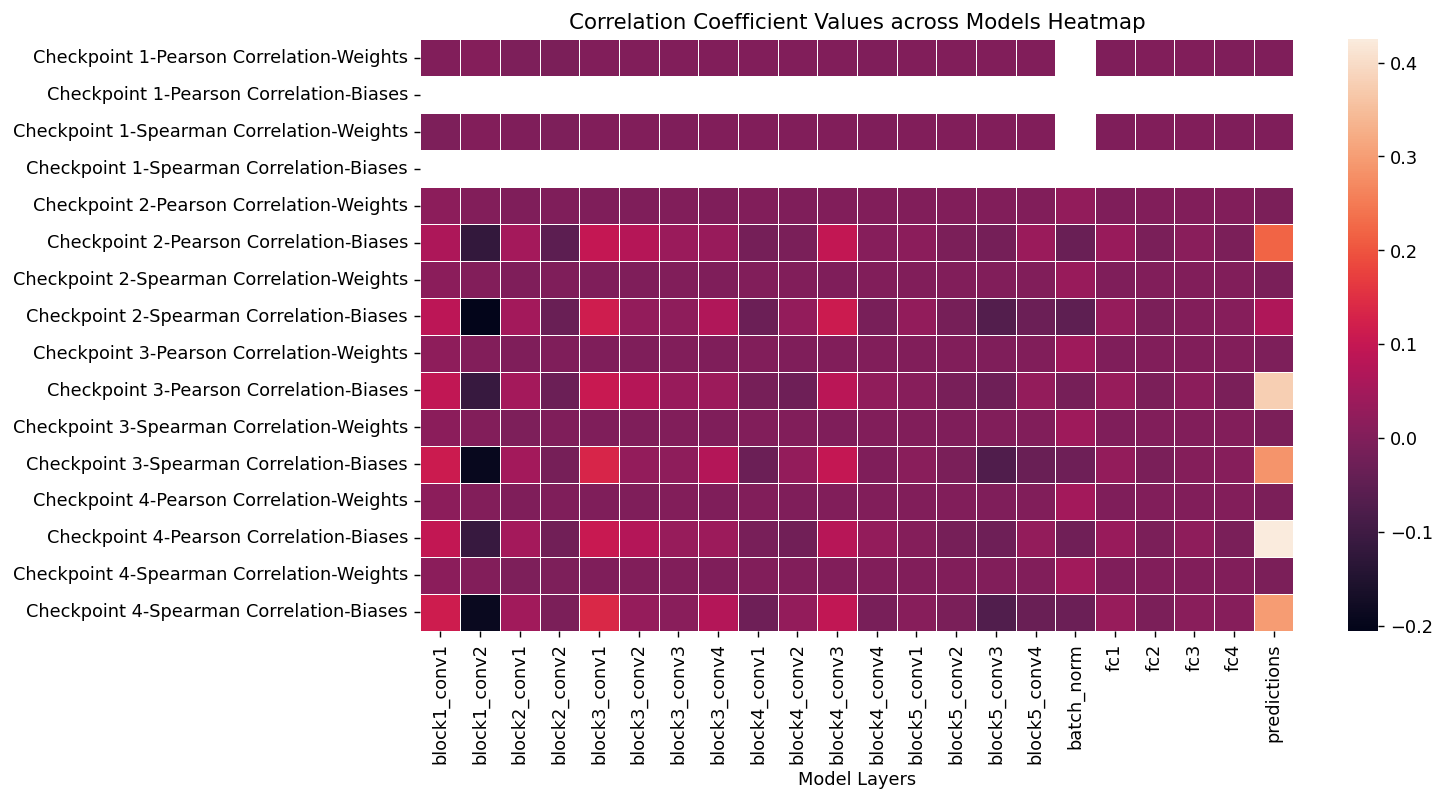

In [22]:
# Correlation Coefficients data visualization
data = overall_corr_data.pivot(index="layer", columns=["checkpoint", "correlation", "value category"], values="value")
data = data.reindex(overall_corr_data["layer"].unique())

plt.figure(figsize=(11, 6), dpi=128)

sns.heatmap(data.T, linewidth=0.5)

plt.xlabel('Model Layers')
plt.ylabel(None)
plt.title('Correlation Coefficient Values across Models Heatmap')

plt.show()